## Implementation of learning action-oriented models through active inference

In this notebook, we will implement the paper: [Learning action-oriented models through active inference, Tschantz et al, 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007805). The paper is concerned with building a model-based agent that learns about the environment and using the learned model to plan for actions which maximize expected reward. The official implementation can be found [here](https://github.com/alec-tschantz/action-oriented).

**Action-oriented** models refer to a type of environment model which *does not* necessarily mirror the true statistics of the environment but supports high quality actions. This is appealing because 1) intuitively any capacity an agent has should contribute towards maximizing reward, and 2) in representation-bounded agents, learning such a misrepresented model may better support reward-optimal behavior. The second point echos some recent research on the [objective mismatch in model-based reinforcement learning](https://arxiv.org/abs/2002.04523), where objectively better models may lead to worse behavior, and the [value equivalence principle](https://arxiv.org/abs/2011.03506) which proposes a framework to align the model-policy objectives. The action-oriented view is also strongly advocated in [embodied cognitive science](https://www.sciencedirect.com/science/article/pii/S0166223621000795).

Specifically, this paper uses active inference, a framework which performs hidden state inference, parameters learning, and policy selection in Partially Observable Markov Decision Processes (POMDP) using variational inference. The benefit of active inference is that it explicitly includes an information gain term in its planning objective to induce epistemic behavior. This way, agents which do and do not include this term in their plans can be compared more straightforwardly. 

In the next section, we will derive the update rules needed to simulate the active inference agent.

## Active inference
In contrast with standard reinforcement leanring, active inference typically does not make assumptions about the true dynamics of the environment, let it be any nonlinear high order Markov model with partial observability and so on. However, it requires the agent to have an internal model of the environment, which is typically a POMDP defined with the following elements: 
* Hidden state space: $\mathcal{X}$
* Action space: $\mathcal{A}$
* Observation space: $\mathcal{O}$
* State transition probabilities: $P(x'|x, a)$
* Observation probabilities: $P(o|x)$

Since we are also concerned with learning about the environment, the state space is partitioned into $\mathcal{X} = \{\mathcal{S}, \mathcal{\Theta}\}$, where $\mathcal{S}$ is the space of actual environment states, and $\mathcal{\Theta}$ is the space of parameters of the transition and observation probabilities. The transition matrix is factored as: $P(s'|s, a; \theta)P(\theta)$.

Active inference requires agents to minimize a free energy function defined as:
\begin{align}
\mathcal{F}(\phi, o) = KL[Q_{\phi}(x) || P(x, o)]
\end{align}
where $KL[\cdot || \cdot]$ denotes KL divergence. $Q_{\phi}(x)$ is a so-called variational distribution over the hidden state $x$ parameterized by $\phi$, which upon optimized can be interpreted as the posterior distribution over the hidden states. 

In practice, active inference agents minimize free energy in two separate steps:
1. Infer hidden states, including the hidden environment state and hidden parameters, by minimizing *variational* free energy
2. Compute the optimal action by minimizing *expected* free energy

### Hidden state inference
After the agent has interacted with the environment for $\tau$ time steps and generating an interaction history $h_\tau = \{o_{1:\tau}, a_{1:\tau-1}\}$, the variational free energy function is defined as:
\begin{align}
\mathcal{F}(\phi, o_{1:\tau}) = \mathbb{E}_{Q_{\phi}(s_{1:\tau}, \theta)}\left[\log Q_{\phi}(s_{1:\tau}, \theta) - \log P(s_{1:\tau}, o_{1:\tau}, \theta|a_{1:\tau-1})\right]
\end{align}

It is typical in the active inference literature to use a factorized variational distribution:
\begin{align}
Q_{\phi}(s_{1:\tau}, \theta) = Q_{\phi}(\theta)\prod_{t=1}^{\tau}Q_{\phi}(s_t)
\end{align}

The variational free energy function can then be written as a sum over different timesteps:
\begin{align}
\begin{split}
\mathcal{F}(\phi, o_{1:\tau}) &= \mathbb{E}_{Q}\left[\log Q(\theta) + \sum_{t=1}^{\tau}\log Q(s_t) - \log P(\theta) - \sum_{t=1}^{\tau}\log P(s_t|s_{t-1}, a_{t-1}; \theta) - \sum_{t=1}^{\tau}P(o_t|s_t; \theta)\right] \\
&=\sum_{t=1}^{\tau}\mathbb{E}_{Q(\theta)Q(s_{t-1}, s_t)}\left[\log Q(s_t) - \log P(s_t|s_{t-1}, a_{t-1}; \theta) - \log P(o_t|s_t; \theta)\right] + \mathbb{E}_{Q(\theta)}[\log Q(\theta) - \log P(\theta)]
\end{split}
\end{align}
where we have omitted $\phi$ to simplify notation. 

It is well known that this type of optimization has to be done w.r.t. each variational factor in an alternating fashion, commonly known as coordinate ascent. When optimizing each factor, we hold all other factors fixed. 

**Hidden state update:** To derive the update rule for the hidden state factor $Q(s_t)$, we will take the derivative of $\mathcal{F}$ w.r.t. $Q(s_t)$:
\begin{align}
\frac{\partial \mathcal{F}}{\partial Q(s_t)} = \mathbb{E}_{Q(\theta)Q(s_{t-1})}\left[\log Q(s_t) - \log P(s_t|s_{t-1}, a_{t-1}; \theta) - \log P(o_t|s_t; \theta)\right] + 1
\end{align}
Setting it to zero we have:
\begin{align}
Q(s_t) = \textit{softmax}\left(\mathbb{E}_{Q(\theta)Q(s_{t-1})}\left[\log P(s_t|s_{t-1}, a_{t-1}; \theta) + \log P(o_t|s_t; \theta)\right]\right)
\end{align}

**Hidden parameter update:** Applying the same procedure to $Q(\theta)$ we have:
\begin{align}
\frac{\partial \mathcal{F}}{\partial Q(\theta)} = \sum_{t=1}^{\tau}\mathbb{E}_{Q(s_{t-1}, s_t)}\left[\log Q(s_t) - \log P(s_{t}|s_{t-1}, a_{t-1}; \theta) - \log P(o_t|s_t; \theta)\right] + \log Q(\theta) - \log P(\theta) + 1
\end{align}
Setting it to zero we have:
\begin{align}
Q(\theta) = \textit{softmax}\left(\sum_{t=1}^{\tau}\mathbb{E}_{Q(s_{t-1}, s_t)}\left[\log P(s_{t}|s_{t-1}, a_{t-1}; \theta) + \log P(o_t|s_t; \theta) - \log Q(s_t)\right] + \log P(\theta)\right)
\end{align}
Note that this softmax normalizes over the continuous parameter values $\theta$.

### Policy computation
Active inference requires agents to choose actions which minimize the expected free energy defined as:
\begin{align}
\mathcal{G}(a_t) = \underbrace{-\mathbb{E}_{Q(o_{t+1}, s_{t+1}, \theta|a_t)}\left[\log P(o_{t+1})\right]}_{\text{Instrumental value}} + \underbrace{\mathbb{E}_{Q(o_{t+1}, s_{t+1}, \theta|a_t)}\left[\log Q(s_{t+1}, \theta|a_t) - \log Q(s_{t+1}, \theta|o_{t+1}, a_t)\right]}_{\text{Epistemic value}}
\end{align}
The distribution $P(o_{t+1})$ in the first term encodes agent preference such that desirable observations have high likliehood, e.g., by making them proportional to the exponential of a reward function. Thus, optimizing the first term optimizes expected reward.

In both terms, the expectations are taken w.r.t. the posterior predictive:
\begin{align}
Q(o_{t+1}, s_{t+1}, \theta|a_t) = Q(\theta)\sum_{s_t}P(o_{t+1}|s_{t+1})P(s_{t+1}|s_t, a_t)Q(s_t)
\end{align}

The second term is also known as information gain (IG) of the hidden state and parameters, which can be written as:
\begin{align}
\begin{split}
IG(a_t) &= \mathbb{E}_{Q(o_{t+1})}\left[\mathbb{E}_{Q(s_{t+1}, \theta|o_{t+1}, a_t)}\left[\log Q(s_{t+1}, \theta|a_t) - \log Q(s_{t+1}, \theta|o_{t+1}, a_t)\right]\right] \\
&= -\mathbb{E}_{Q(o_{t+1})}KL\left[Q(s_{t+1}, \theta|o_{t+1}, a_t) || Q(s_{t+1}, \theta|a_t)\right]
\end{split}
\end{align}

The expected free energy can be extended by summing over multiple future time steps or an infinite number of future timesteps with a discount factor to bring it closer to the reinforcement learning setting. 

## Experiment test bed: Bacterial chemotaxi
We will replicate the authors' experiment in an environment called bacterial chemotaxi. Here, we have a bacteria (a point mass) swimming in a 2D environment where there is a spot with a chemical source such that the closer to the source the higher the chemical concentration. While the chemical concentration decreases in a continuous and smooth fashion as one more away the source, we will equip with the bacteria with a *discrete* generative model. The bacteria can observe whether the current chemical concentration gradient is positive $o^{pos}$ or negative $o^{neg}$ and it can choose from two actions: run $a^{run}$ and tumble $a^{tumble}$. Running causes the agent to more forward by a single unit of velocity in the direction of their current orientation. Tumbling causes the agent to sample a new orientation at random. 

To make it more specific, let us denote the source's and the bacteria's coordinates on the 2D map with $(x_s, y_s)$ and $(x_b, y_b)$. Further, let's use $\theta$ to denote the bacteria's orientation. We can check whether the chemical concentration is increasing or decreasing along the bacteria's orientation by computing the difference in angles between the bacteria's orientation and the angle of the vector pointing from the bacteria's location to the source. This angle, let's call it $\theta^{+}$, can be computed as:
\begin{align}
\theta^{+} = \textit{np.arctan2}(y_s - y_b, x_s - x_b)
\end{align}

To move the bacteria, let us denote a the velocity with $v$, the bacteria's new position can be computed as:
\begin{align}
(x_b', y_b') = (x_b + v \cdot \cos\theta, y_b + v \cdot \sin\theta)
\end{align}

Finally, we will set the bacteria's preference distribution such that $o^{pos}$ has high likelihood. It will then plan to maximize the liklihood of observing $o^{pos}$.

## Implementation
With the environment defined above, we have two observations and two actions. We will follow the authors by using two hidden environment states and assuming the observation matrix is an identity matrix, which is equivalent to assuming the environment state is fully observable, and the bacteria already knows it. Thus, there is not need for hidden state inference and parameter learning about the observation matrix. We will follow the authors by using a Dirichlet prior on the transition matrix parameters where each row in the transition matrix is associated with a Dirichlet distribution. The parameters, denoted by $\alpha$, for the set of Dirichlet distributions is a $|\mathcal{A}| \times |\mathcal{S}| \times |\mathcal{S}|$ matrix with all positive entries. Using the Dirichlet-Categorical conjugacy, the parameters can be updated by counting the number of transitions:
\begin{align}
\alpha_{kij}^{\tau} = \sum_{t=1}^{\tau}\mathbb{I}[a_{t-1}=k, s_{t-1}=i, s_t=j]
\end{align}
where $\mathbb{I}[\cdot]$ denotes the indicator function. *The authors in constrast used a gradient descent method to update the parameters.*

With the fully state observability assumption, the expected free energy reduces to:
\begin{align}
\mathcal{G}(a_t) = -\mathbb{E}_{Q(s_{t+1}|s_t, a_t)}\left[\log P(s_{t+1})\right] + IG(a_t)
\end{align}
where
\begin{align}
\begin{split}
IG(a_t) &= \mathbb{E}_{Q(s_{t+1}, \theta|s_t, a_t)}\left[\log Q(\theta) - \log Q(\theta|s_{t+1}, s_t, a_t)\right] \\
&= -\mathbb{E}_{Q(s_{t+1}|s_t, a_t)}KL\left[Q(\theta|s_{t+1}, s_t, a_t) || Q(\theta)\right]
\end{split}
\end{align}
The outer expectation is taken under $Q(s_{t+1}|s_t, a_t) = \int_{\theta}P(s_{t+1}|s_t, a_t; \theta)Q(\theta)$, which is the transition probability expected under the Dirichlet distribution. The first term in the KL divergnce is the Dirichlet posterior had the hypothetical $s_{t+1}$ been observed, which can be computed in closed form using the Dirichlet-Categorical conjugacy. Thus, *in contrast to the authors*, we will compute the information gain term in closed form as the negative expected KL divergence between the posterior and prior Dirichlet distributions.

The last thing we will add is a set of parameters $(\alpha, \beta)$ used to weight the contribution of the expected reward and information gain. 

We are now ready to implement.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as torch_dist

import warnings
warnings.filterwarnings("ignore")

In [ ]:
seed = 0

# set plotting style
strip_size = 12
label_size = 14
mpl.rcParams["axes.labelsize"] = label_size
mpl.rcParams["xtick.labelsize"] = strip_size
mpl.rcParams["ytick.labelsize"] = strip_size
mpl.rcParams["legend.title_fontsize"] = strip_size
mpl.rcParams["axes.titlesize"] = label_size
mpl.rcParams["figure.titlesize"] = label_size

In [ ]:
def to_circle(x):
    """ Round angles to interval [-pi, pi] 
    
    Args:
        x (np.array): input angles in range [-inf, inf]
        return_revs(bool, optional): return wrap revolutions

    Returns:
        y (np.array): output angels in range [-pi, pi]
    """
    y = (x + np.pi) % (2 * np.pi) - np.pi
    return y

class Env:
    """ Bacterial chemotaxi environment """
    def __init__(self, init_distance, vel):
        """
        Args:
            init_distance (float): agent initial distance from source
            vel (float): agent velocity
        """
        self.state_dim = 2
        self.act_dim = 2

        self.init_distance = init_distance
        self.vel = vel # movement velocity unit
        
        # true transition matrix
        self.transition = torch.tensor(
            [[[1, 0], [0, 1]], [[0.5, 0.5], [0.5, 0.5]]]
        )

    def reset(self):
        # init source
        self.s_pos = np.array([0, 0])

        # init agent position
        rand_dir = np.random.rand() * 2 * np.pi - np.pi # random direction from source
        b_x = self.init_distance * np.cos(rand_dir)
        b_y = self.init_distance * np.sin(rand_dir)
        self.pos = np.array([b_x, b_y])

        # init agent orientation
        self.theta = np.random.rand() * 2 * np.pi - np.pi
        return self.observe()
    
    def observe(self):
        # source direction
        s_dir = np.arctan2(-self.pos[1], -self.pos[0])
        theta_diff = to_circle(self.theta - s_dir)
        
        if np.abs(theta_diff) > np.pi/2:
            o = 1 # negative gradient
        else:
            o = 0 # positive gradient
        return o

    def step(self, a):
        if a == 0: # run
            self.pos[0] += self.vel * np.cos(self.theta)
            self.pos[1] += self.vel * np.sin(self.theta)
        else: # tumble
            self.theta = np.random.rand() * 2 * np.pi - np.pi

        return self.observe()

In [ ]:
def simulate(env, agent, test=False, max_steps=1000):
    """ Simulate trajectory in environment """
    if test:
        agent.eval = True
        agent.alpha = 1. # set instrumental value to 1.
        agent.beta = 0. # set epistemic value to 0.
        agent.random_policy = False

    data = {"pos": [], "theta": [], "o": [], "a": [], "kl_true": []}
    o = env.reset()
    pos = env.pos.copy()
    theta = env.theta
    for t in range(max_steps):
        a = agent.choose_action(o)
        o_next = env.step(a)

        data["pos"].append(pos.copy())
        data["theta"].append(theta)
        data["o"].append(o)
        data["a"].append(a)

        # compute agent parameters kl divergence from truth
        true_transition = torch_dist.Categorical(env.transition + 1e-6)
        agent_transition = torch_dist.Categorical(agent.compute_transition())
        data["kl_true"].append(
            torch_dist.kl.kl_divergence(agent_transition, true_transition).clone().sum()
        )

        o = o_next
        pos = env.pos.copy()
        theta = env.theta
    data["pos"] = np.stack(data["pos"])
    data["theta"] = np.array(data["theta"])
    data["kl_true"] = torch.stack(data["kl_true"])
    data["final_dist"] = np.sqrt(sum(data["pos"][-1]**2))
    return data

In [ ]:
class Agent:
    def __init__(self, state_dim, act_dim, r, alpha=1., beta=1., random_policy=False):
        """
        Args:
            state_dim (int): state dimension
            act_dim (int): action dimension
            r (torch.tensor): preference probabilities
            alpha (float, optional): instrumental value weight. Default=1.
            beta (float, optional): information gain weight. Default=1.
            random_policy (bool): whether to use random policy. Default=False
        """
        self.state_dim = state_dim
        self.act_dim = act_dim
        self.lr = lr
        self.alpha = alpha
        self.beta = beta
        self.random_policy = random_policy
        self.eval = False # whether the agent is in the eval mode
        
        self.r = r
        self.theta = torch.rand(act_dim, state_dim, state_dim) + 1e-6
        self.theta0 = self.theta.clone()
        self.transition0 = self.compute_transition()

        self.history = {"a": [], "o": [], "q": [], "ig": [], "kl_0": []}
        self.pseudo_count = torch.zeros(act_dim, state_dim, state_dim) # historical transition counts
    
    def compute_transition(self):
        theta = self.theta / self.theta.sum(-1, keepdim=True)
        return theta

    def update_theta(self):
        """ Update dirichlet count parameters """
        if len(self.history["o"]) > 1:
            a = torch.tensor(self.history["a"][-2])
            o = torch.tensor(self.history["o"][-2])
            o_next = torch.tensor(self.history["o"][-1])

            o = F.one_hot(o, num_classes=self.state_dim)
            o_next = F.one_hot(o_next, num_classes=self.state_dim)
            
            self.pseudo_count[a] += o.unsqueeze(-1) * o_next.unsqueeze(-2)

            self.theta = self.theta0 + self.pseudo_count

    def compute_information_gain(self, s):
        p = self.compute_transition()[:, s]
        
        kl = torch.zeros(self.act_dim, self.state_dim)
        for a in range(self.act_dim):
            for s_next in range(self.state_dim):
                theta_post = self.theta.clone()
                theta_post[a, s, s_next] += 1 # dirichlet-categorical conjugacy
                dir_post = torch_dist.Dirichlet(theta_post)
                dir_prior = torch_dist.Dirichlet(self.theta)
                kl[a][s_next] += torch_dist.kl.kl_divergence(dir_post, dir_prior).sum()
        
        ig = -torch.sum(p * kl, dim=-1)
        return ig
    
    def compute_expected_reward(self, s):
        p = self.compute_transition()[:, s]
        logp = torch.log(self.r).unsqueeze(0)
        q = -torch.sum(p * logp, dim=-1)
        return q

    def compute_efe(self, s):
        q = self.compute_expected_reward(s)
        ig = self.compute_information_gain(s)
        efe = self.alpha * q + self.beta * ig
        
        self.history["q"].append(q)
        self.history["ig"].append(ig)
        return efe

    def choose_action(self, o):
        g = self.compute_efe(o)
        
        if self.random_policy:
            a = torch.multinomial(torch.ones(self.act_dim), 1)[0].item()
        else:
            g_min = g.min()
            options = torch.zeros(self.act_dim)
            options[torch.where(g == g_min)] = 1
            a = torch.multinomial(options, 1)[0].item()

        self.history["o"].append(o)
        self.history["a"].append(a)

        if not self.eval:
            self.update_theta()
            
            # compute expected transition kl divergence from initialization
            transition_init = torch_dist.Categorical(self.transition0)
            transition_now = torch_dist.Categorical(self.compute_transition())
            self.history["kl_0"].append(
                torch_dist.kl.kl_divergence(transition_init, transition_now).clone()
            )
            
        return a

In [ ]:
def plot_trajectory(data, ax=None, figsize=(6, 6)):
    """ Plot agent trajectory on 2D map """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # find agent trajectory boundaries
    x_max = max(0, data["pos"][:, 0].max()) + 10
    x_min = min(0, data["pos"][:, 0].min()) - 10
    y_max = max(0, data["pos"][:, 1].max()) + 10
    y_min = min(0, data["pos"][:, 1].min()) - 10

    # plot chemical concentration contour 
    x = np.linspace(x_min, x_max, 100)
    y = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.sqrt(X**2 + Y**2)
    ax.contour(X, Y, Z, colors="black", linestyle="dashed");
    
    # plot agent trajectory
    ax.plot(data["pos"][:, 0], data["pos"][:, 1])
    ax.plot(data["pos"][0, 0], data["pos"][0, 1], "b*", ms=12, label="start")
    ax.plot(data["pos"][-1, 0], data["pos"][-1, 1], "r*", ms=12, label="end")
    ax.plot([0], [0], "g*", ms=12, label="source")
    ax.legend()
    plt.tight_layout()
    return ax

def plot_history(data, history, agent_name=""):
    q = torch.stack(history["q"])
    ig = torch.stack(history["ig"])

    fig, ax = plt.subplots(2, 2, figsize=(14, 6), sharex=True)
    ax[0, 0].plot(data["a"])
    ax[1, 0].plot(data["o"])

    ax[0, 1].plot(q[:1000, 0], label="run")
    ax[0, 1].plot(q[:1000, 1], label="tumble")

    ax[1, 1].plot(ig[:1000, 0], label="run")
    ax[1, 1].plot(ig[:1000, 1], label="tumble")

    ax[0, 0].set_ylabel("a")
    ax[0, 0].set_yticks([0, 1])
    ax[0, 0].set_yticklabels(["run", "tumble"])

    ax[1, 0].set_ylabel("o")
    ax[1, 0].set_xlabel("time")
    ax[1, 0].set_yticks([0, 1])
    ax[1, 0].set_yticklabels(["pos", "neg"])

    ax[0, 1].set_ylabel("(-) expected reward")
    ax[0, 1].legend()

    ax[1, 1].set_ylabel("(-) information gain")
    ax[1, 1].set_xlabel("time")
    ax[1, 1].legend()

    plt.suptitle(f"{agent_name} agent's training process")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    return fig, ax

## Experiments
We will follow the paper's protocal by comparing 4 agents:
* EFE agent which plans to optimize expected reward + information gain
* Instrumental agent which plans to optimize expected reward
* Epistemic agent which plans to optimize information gain
* Random agent which takes actions at random

We will initialize all agent 100 units from the source with a velocity of 0.1. We will let all agents learn using the same parameter update rule defined previously for 1000 steps. After the initial 1000 steps, we will reset the environment and let all agents plan w.r.t. expected reward only. This is where we **deviate from the paper** but in my opinion removes the randomness caused by epistemic actions. Another difference between us and the paper is the scale we add to the information gain term, since we compute it using a different method than the paper. We will use $\beta=10$ to put it on the same scale as the expected reward we observed from the experiments.

In [ ]:
# efe agent
np.random.seed(seed)
torch.manual_seed(seed)

# env params
init_distance = 100
v = 0.1

env = Env(init_distance, v)

# agent params
state_dim = env.state_dim
act_dim = env.act_dim
r = torch.Tensor([0.9, 0.1])
alpha = 1.
beta = 10. # set to match the scale of expected reward

efe_agent = Agent(state_dim, act_dim, r, lr=lr, alpha=alpha, beta=beta, random_policy=False)

train_data_efe = simulate(env, efe_agent, max_steps=1000)
test_data_efe = simulate(env, efe_agent, test=True, max_steps=4000)

In [ ]:
# instrumental agent
np.random.seed(seed)
torch.manual_seed(seed)

# env params
init_distance = 100
v = 0.1

env = Env(init_distance, v)

# agent params
state_dim = env.state_dim
act_dim = env.act_dim
r = torch.Tensor([0.9, 0.1])
alpha = 1.
beta = 0.

instrumental_agent = Agent(state_dim, act_dim, r, lr=lr, alpha=alpha, beta=beta, random_policy=False)

train_data_instrumental = simulate(env, instrumental_agent, max_steps=1000)
test_data_instrumental = simulate(env, instrumental_agent, test=True, max_steps=4000)

In [ ]:
# epistemic agent
np.random.seed(seed)
torch.manual_seed(seed)

# env params
init_distance = 100
v = 0.1

env = Env(init_distance, v)

# agent params
state_dim = env.state_dim
act_dim = env.act_dim
r = torch.Tensor([0.9, 0.1])
alpha = 0.
beta = 1.

epistemic_agent = Agent(state_dim, act_dim, r, lr=lr, alpha=alpha, beta=beta, random_policy=False)

train_data_epistemic = simulate(env, epistemic_agent, max_steps=1000)
test_data_epistemic = simulate(env, epistemic_agent, test=True, max_steps=4000)

In [ ]:
# random agent
np.random.seed(seed)
torch.manual_seed(seed)

# env params
init_distance = 100
v = 0.1

env = Env(init_distance, v)

# agent params
state_dim = env.state_dim
act_dim = env.act_dim
r = torch.Tensor([0.9, 0.1])
alpha = 0.
beta = 0.

random_agent = Agent(state_dim, act_dim, r, lr=lr, alpha=alpha, beta=beta, random_policy=True)

train_data_random = simulate(env, random_agent, max_steps=1000)
test_data_random = simulate(env, random_agent, test=True, max_steps=4000)

## Results

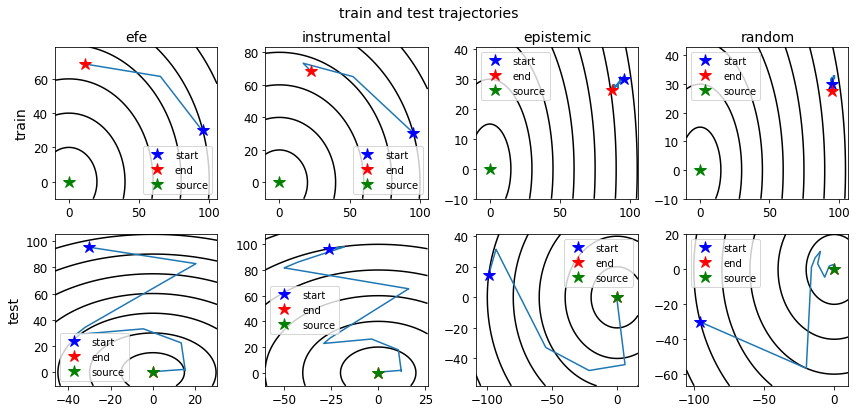

In [ ]:
# plot agent trajectories
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
plot_trajectory(train_data_efe, ax=ax[0, 0])
plot_trajectory(train_data_instrumental, ax=ax[0, 1])
plot_trajectory(train_data_epistemic, ax=ax[0, 2])
plot_trajectory(train_data_random, ax=ax[0, 3])

plot_trajectory(test_data_efe, ax=ax[1, 0])
plot_trajectory(test_data_instrumental, ax=ax[1, 1])
plot_trajectory(test_data_epistemic, ax=ax[1, 2])
plot_trajectory(test_data_random, ax=ax[1, 3])

ax[0, 0].set_title("efe")
ax[0, 1].set_title("instrumental")
ax[0, 2].set_title("epistemic")
ax[0, 3].set_title("random")

ax[0, 0].set_ylabel("train")
ax[1, 0].set_ylabel("test")

plt.suptitle("train and test trajectories")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Here we plot the train and test trajectories for each agent. The black contour lines represent directions orthogonal to the chemical source direction, which means orthogonal to those lines have the highest chemical concentration gradients and they are the desired travel directions.

During the training phase, it is clear that both the epistemic and random agents were just taking random walks and did not move too far. For the efe and instrumental agents, we can't realy tell the difference other than that the instrumental agent took another turn close to the end of the training phase. We would have to visualize what these two agents actually observed and their evaluations of expected reward and information gain to understand their behavior. We will do this in the next block.

For the testing phase, all agents reached the source at the end of the testing phase. This is different from the paper but this might be due to how our environment is set up and the velocity is chosen. 

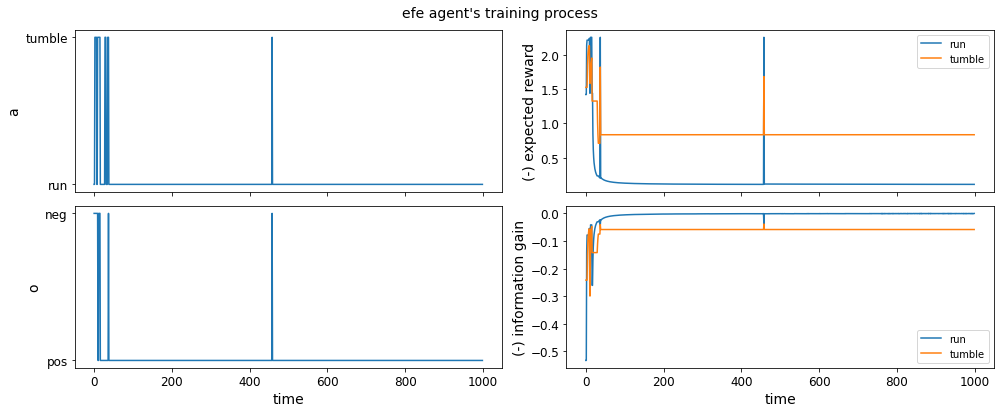

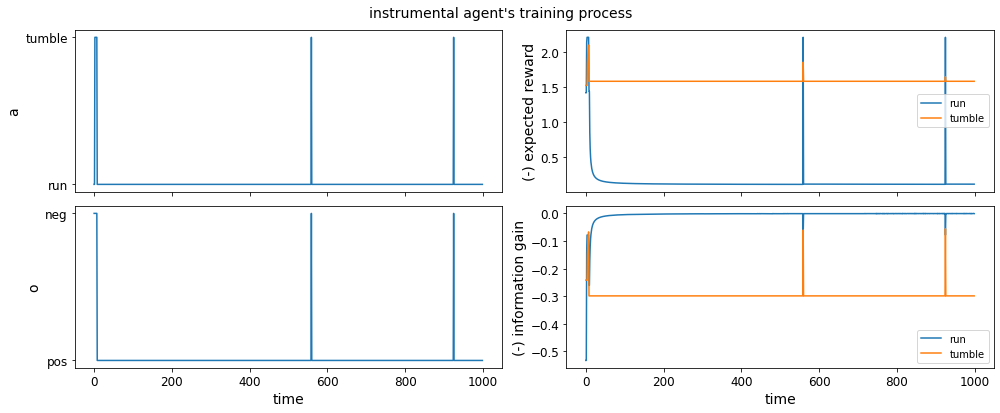

In [ ]:
plot_history(train_data_efe, efe_agent.history, agent_name="efe")
plt.show()

plot_history(train_data_instrumental, instrumental_agent.history, agent_name="instrumental")
plt.show()

These two figures show the actions taken by the efe and instrumental agents and the gradient signals they each observed. On the right, the figures show the expected reward and information gain evaluated by the agents at each time step, except that the instrumental agent did not use information gain in its plans -- its just for our analysis' sake. 

First, the plots passed the sanity check because: 1) the expected rewards for tumbling were higher when the agents observed negative gradients, and 2) the expected information gain for running decreased overtime as the running action was taken frequently.

To address the question in the previous figure -- what is the difference between the efe and instrumental agent? In terms of the trajectories, the instrumental agent observed another negative gradient towards the end. Since both agents have learned they should tumble when observing negative gradients (for their respective reasons), the instrumental agent had one more turn in the trajectory as a result of tumbling. 

Second, we see that the difference in expected information gain between the two actions for the efe agent is much smaller than that of the instrumental agent. A likely reason is that the efe agent was gaining experience about all state-action transitions and thus left little to be learned towards the end of the learning phase, whereas the instrumental agent might have never experienced certain state-action transitions as it never sampled them. We can partially see this in the first 50 steps of the efe agent where it selected more tumbling than the instrumental agent and thus gained better knowledge about the consequences of tumbling.

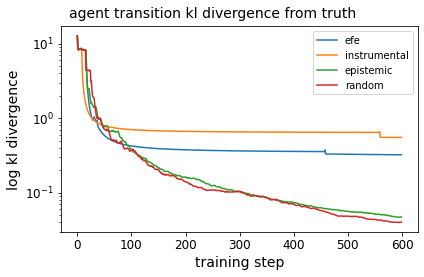

In [ ]:
# plot agent transition kl divergence from truth
kl_true_efe = train_data_efe["kl_true"]
kl_true_instrumental = train_data_instrumental["kl_true"]
kl_true_epistemic = train_data_epistemic["kl_true"]
kl_true_random = train_data_random["kl_true"]

t_max = 600
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(kl_true_efe[:t_max], label="efe")
ax.plot(kl_true_instrumental[:t_max], label="instrumental")
ax.plot(kl_true_epistemic[:t_max], label="epistemic")
ax.plot(kl_true_random[:t_max], label="random")
ax.set_yscale("log")

ax.set_xlabel("training step")
ax.set_ylabel("log kl divergence")
ax.legend()

plt.suptitle("agent transition kl divergence from truth")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

This figure shows the log kl divergence between the expected transition probabilities believed by the agents and the true transition probabilities over the course of training. We see that efe and instrumental agent's kl divergence decreased faster than the epistemic and random agents initially. But their kl divergences also leveled off much faster. Overall, the instrumental agent had the highest kl divergence, meaning it learned the least accurate model of the environment, and the epistemic agent had the lowest kl divergence. The efe agent learned a slightly more accurate model than the instrumental agent. On this part we agree with the authors.

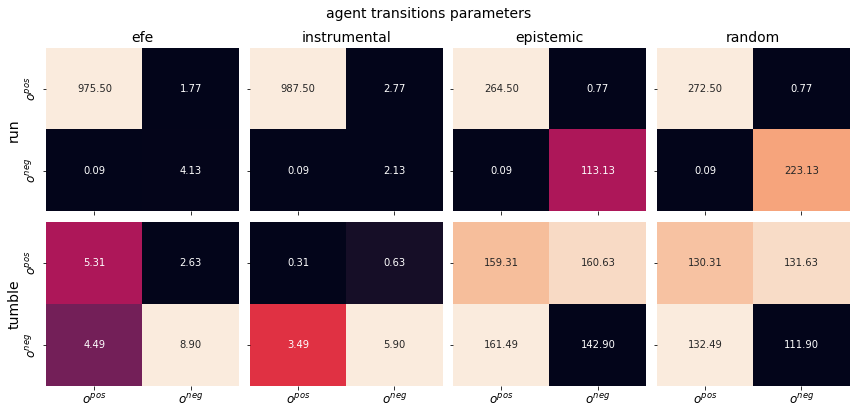

In [ ]:
# plot agent final parameters
efe_theta = efe_agent.theta
instrumental_theta = instrumental_agent.theta
epistemic_theta = epistemic_agent.theta
random_theta = random_agent.theta

theta = torch.stack([
    efe_theta, instrumental_theta,
    epistemic_theta, random_theta
])

fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for i in range(4):
    sns.heatmap(theta[i, 0], fmt=".2f", annot=True, cbar=False, ax=ax[0, i])
    sns.heatmap(theta[i, 1], fmt=".2f", annot=True, cbar=False, ax=ax[1, i])
    ax[0, i].set_xticklabels([r"$o^{pos}$", r"$o^{neg}$"])
    ax[0, i].set_yticklabels([r"$o^{pos}$", r"$o^{neg}$"])

ax[0, 0].set_title("efe")
ax[0, 1].set_title("instrumental")
ax[0, 2].set_title("epistemic")
ax[0, 3].set_title("random")

ax[0, 0].set_ylabel("run")
ax[1, 0].set_ylabel("tumble")

plt.suptitle("agent transitions parameters")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

This figure shows the final parameters -- the Dirichlet concentration parameters $\alpha$ -- learned by the agents. The parameter values also show how many times the agent experienced a state-action transition as each time they experience a transition it is getting added to the parameters. We see that the efe and instrumental agents chose much fewer tumble actions overall than the epistemic and random agents. Compared with the instrumental agent, the efe agent however chose more tumbling actions when observing positive gradients. 

Furthermore, the efe and instrumental agents believed that tumbling when observing negative gradients will lead to negative gradients in the next time step with much higher probability than the epistemic and random agents. This is likeliy due to the fact that the efe and instrumental agents have experienced much fewer negative to positive transitions when tumbling. Because as soon as they see a positive gradient they would immediately switch to goal-directed behavior with running.

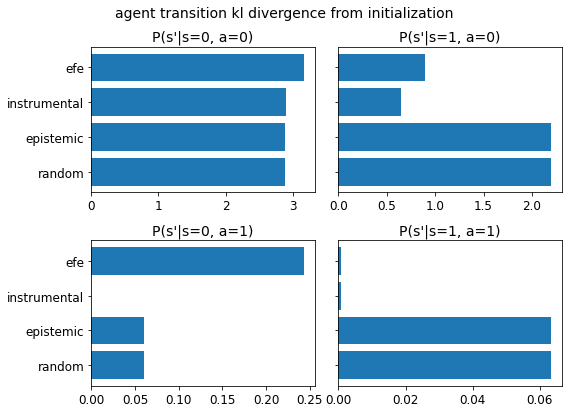

In [ ]:
# plot agent transition kl divergence from initialization
kl_0_efe = torch.stack(efe_agent.history["kl_0"])[-1]
kl_0_instrumntal = torch.stack(instrumental_agent.history["kl_0"])[-1]
kl_0_epistemic = torch.stack(epistemic_agent.history["kl_0"])[-1]
kl_0_random = torch.stack(epistemic_agent.history["kl_0"])[-1]

kl_0 = torch.stack([kl_0_efe, kl_0_instrumntal, kl_0_epistemic, kl_0_random])

fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey=True)
for i in range(2):
    for j in range(2):
        ax[i, j].barh(np.arange(len(kl_0)), list(kl_0[:, i, j])[::-1])
        ax[i, j].set_title(f"P(s'|s={j}, a={i})")

ax[0, 0].set_yticks(np.arange(4))
ax[0, 0].set_yticklabels(["efe", "instrumental", "epistemic", "random"][::-1], rotation=0)
ax[1, 0].set_yticks(np.arange(4))
ax[1, 0].set_yticklabels(["efe", "instrumental", "epistemic", "random"][::-1], rotation=0)

plt.suptitle("agent transition kl divergence from initialization")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

This figure simply reproduces one of the figures from the paper where we compare the kl divergence between the expected transition probabilites when the agents were initialized and when the agents finished training. The message here is similar to the previous figure that the epistemic and random agents learned more evenly about all transitions and the instrumental agent simply did not learn about tumbling when observing negative gradients. 

## Conclusion
While we didn't completely reproduce the paper due to a few differences in our implementation: 
1. our environment and velocity settings might be different
2. we computed the expected information gain exactly
3. our information gain coefficient is different

the overall results were similar to those observed by the authors. If there is one takeaway it has to be this:
* Exploration enables the agent to learn a more accurate model of the environment

However, there is a tradeoff in how much exploration to do, represented by the weighting coefficient $\beta$ in our agents. 

A more important question which motivated me to replicate this experiment is *what exactly is an action-oriented model?* Do we have an answer now? Is it just a model that does not care about learning transitions that are less relevant to the goal or perhaps biases the transitions towards states with higher expected reward in some way? I believe its too simple to be a satisfying answer and it is still a wide-open question.

